In [ ]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class Actor:
    def __init__(self, state_dim, action_dim, max_action):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_action = max_action

        state_input = tf.keras.layers.Input(shape=(state_dim,))
        dense1 = tf.keras.layers.Dense(400, activation='relu')(state_input)
        dense2 = tf.keras.layers.Dense(300, activation='relu')(dense1)
        output = self.max_action * tf.keras.layers.Dense(action_dim, activation='tanh')(dense2)

        self.model = tf.keras.Model(state_input, output)

    def __call__(self, state):
        return self.model(state)

class Critic:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        state_input = tf.keras.layers.Input(shape=(state_dim,))
        action_input = tf.keras.layers.Input(shape=(action_dim,))
        concat1 = tf.keras.layers.Concatenate()([state_input, action_input])
        dense1 = tf.keras.layers.Dense(400, activation='relu')(concat1)
        dense2 = tf.keras.layers.Dense(300, activation='relu')(dense1)
        output1 = tf.keras.layers.Dense(1)(dense2)

        self.model1 = tf.keras.Model([state_input, action_input], output1)

        concat2 = tf.keras.layers.Concatenate()([state_input, action_input])
        dense3 = tf.keras.layers.Dense(400, activation='relu')(concat2)
        dense4 = tf.keras.layers.Dense(300, activation='relu')(dense3)
        output2 = tf.keras.layers.Dense(1)(dense4)

        self.model2 = tf.keras.Model([state_input, action_input], output2)

    def __call__(self, state, action):
        q1 = self.model1([state, action])
        q2 = self.model2([state, action])
        return q1, q2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class TD3:
    def __init__(self, state_dim, action_dim, max_action):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_action = max_action

        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.model.set_weights(self.actor.model.get_weights())

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.model1.set_weights(self.critic.model1.get_weights())
        self.critic_target.model2.set_weights(self.critic.model2.get_weights())

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        return self.actor(state)[0].numpy()

    def train(self, replay_buffer, batch_size=100):
        state, action, next_state, reward, done = replay_buffer.sample(batch_size)

        noise = tf.clip_by_value(tf.random.normal(shape=(batch_size, self.action_dim), mean=0.0, stddev=0.2), -0.5, 0.5)
        next_action = tf.clip_by_value(self.actor_target(next_state) + noise, -self.max_action, self.max_action)

        target_q1, target_q2 = self.critic_target(next_state, next_action)
        target_q = tf.minimum(target_q1, target_q2)
        target_q = reward + (1 - done) * 0.99 * target_q

        with tf.GradientTape(persistent=True) as tape:
            q1, q2 = self.critic(state, action)
            critic_loss = tf.reduce_mean((q1 - target_q) ** 2 + (q2 - target_q) ** 2)

        critic_grads = tape.gradient(critic_loss, self.critic.model1.trainable_variables + self.critic.model2.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.model1.trainable_variables + self.critic.model2.trainable_variables))

        with tf.GradientTape() as tape:
            actor_loss = -tf.reduce_mean(self.critic(state, self.actor(state))[0])

        actor_grads = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.model.trainable_variables))

        for param, target_param in zip(self.critic.model1.trainable_variables + self.critic.model2.trainable_variables,
                                       self.critic_target.model1.trainable_variables + self.critic_target.model2.trainable_variables):
            target_param.assign(0.995 * target_param + 0.005 * param)

        for param, target_param in zip(self.actor.model.trainable_variables,
                                       self.actor_target.model.trainable_variables):
            target_param.assign(0.995 * target_param + 0.005 * param)


In [ ]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.done = np.zeros((max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (tf.convert_to_tensor(self.state[ind], dtype=tf.float32),
                tf.convert_to_tensor(self.action[ind], dtype=tf.float32),
                tf.convert_to_tensor(self.next_state[ind], dtype=tf.float32),
                tf.convert_to_tensor(self.reward[ind], dtype=tf.float32),
                tf.convert_to_tensor(self.done[ind], dtype=tf.float32))

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

td3 = TD3(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer(state_dim, action_dim)

episode_rewards = []

for episode in range(100):
    state = env.reset()
    episode_reward = 0

    for step in range(env._max_episode_steps):
        action = td3.select_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, next_state, reward, done)
        td3.train(replay_buffer)

        state = next_state
        episode_reward += reward

        if done:
            break

    episode_rewards.append(episode_reward)
    print(f'Episode: {episode}, Reward: {episode_reward}')

Episode: 0, Reward: -0.18224693224713603
Episode: 1, Reward: -0.033947085683879615
Episode: 2, Reward: -0.04988408860818491
Episode: 3, Reward: -0.06458329421687595
Episode: 4, Reward: -0.1282065590433787
Episode: 5, Reward: -0.12345816516734551
Episode: 6, Reward: -0.07287428024298306
Episode: 7, Reward: -0.06764929739113196
Episode: 8, Reward: -0.04102419535788035
Episode: 9, Reward: -0.07782976480143732
Episode: 10, Reward: -0.0680326191380641
Episode: 11, Reward: -0.0695133344280816
Episode: 12, Reward: -0.06362663475962045
Episode: 13, Reward: -0.09221440798748384
Episode: 14, Reward: -0.15273392052359125
Episode: 15, Reward: -0.2710411267256031
Episode: 16, Reward: -0.254110457168784
Episode: 17, Reward: -0.06902910071854797
Episode: 18, Reward: -0.013180251273925836
Episode: 19, Reward: -0.057534772910814984
Episode: 20, Reward: -0.15788025986301257
Episode: 21, Reward: -0.05330462314273602
Episode: 22, Reward: -0.08937408004367904
Episode: 23, Reward: -0.04510349928892898
Episo

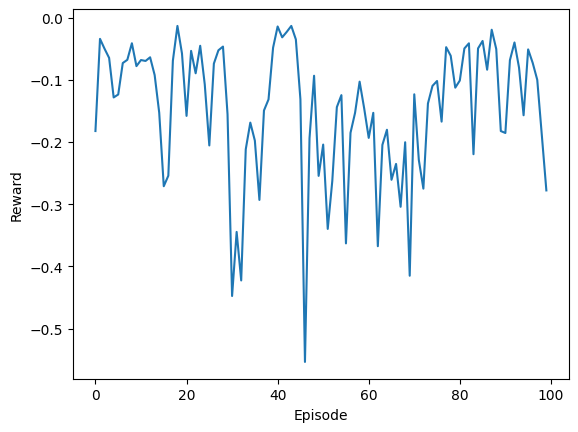

In [ ]:
# Plot the episode rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()